A notebook which contains timeseries of SalishSeaCast model output and observed data within PugetSound for the year 2009. This script is designed so that changes the the observed and model data over time can be easily compared.

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [56]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import xarray as xr
import datetime as dt
import Keegan_eval_tools as ket
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
year=2010
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [4]:
display(Markdown('''## Year: '''+ str(year)))

## Year: 2010

In [5]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

In [6]:
##### Loading in pickle file data
saveloc='/ocean/kflanaga/MEOPAR/savedData'

with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{year}.pkl'),'rb') as hh:
    data=pickle.load(hh)
    
with open(os.path.join(saveloc,f'data_Pheo_{modelversion}_{year}.pkl'),'rb') as hh:
    data_Pheo=pickle.load(hh)

In [7]:
def TsByRegion(datreg,regions,obsvar,modvar,year,loc='lower left',units='($\mu$M)'):
    fig,ax=plt.subplots(math.ceil(len(regions)/2),2,figsize=(13,13))
    new_reg = [regions[i:i+2] for i in range(0, len(regions), 2)]
    for ri,axi in zip(new_reg,ax):
        for rj,axj in zip(ri,axi):
            ps=ket.tsertser_graph(axj,datreg[rj],obsvar,modvar,dt.datetime(year,1,1),dt.datetime(year,12,31))
            axj.legend(handles=ps,prop={'size': 10},loc=loc)
            axj.set_xlabel(f'Date',fontsize=13)
            axj.set_ylabel(f'{obsvar} {units}',fontsize=13)
            axj.set_title(f'Time series for {rj}', fontsize=13)
            yearsFmt = mdates.DateFormatter('%d %b')
            axj.xaxis.set_major_formatter(yearsFmt)
            for tick in axj.xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
            for tick in axj.yaxis.get_major_ticks():
                tick.label.set_fontsize(13)
            plt.tight_layout()
            plt.setp(axj.get_xticklabels(), rotation=30, horizontalalignment='right')

def TsByDepth(df,obsvar,modvar,year,title,units='($\mu$M)'):
    fig,ax=plt.subplots(1,1,figsize=(18,8))
    ps=ket.tsertser_graph(ax,df,obsvar,modvar,dt.datetime(year,1,1),dt.datetime(year,12,31))
    ax.legend(handles=ps,bbox_to_anchor=[1,.6,0,0])
    ax.set_xlabel(f'Date',fontsize=20)
    ax.set_ylabel(f'{obsvar} {units}',fontsize=20)
    ax.set_title(f'{title}', fontsize=22)
    yearsFmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(yearsFmt)

# I know I found a solution to this problem of mine in the past that     
    
def TsByStation(df,region,datstat,obsvar,modvar,year):
    for s,a in df[df.Basin == region].Station.unique():
        fig,ax=plt.subplots(1,1,figsize=(18,8))
        ps=ket.tsertser_graph(ax,datstat[s],obsvar,modvar,dt.datetime(year,1,1),dt.datetime(year,12,31))
        ax.legend(handles=ps,bbox_to_anchor=[1,.6,0,0])
        ax.set_xlabel(f'Date',fontsize=20)
        ax.set_ylabel(f'{obsvar} ($\mu$M)',fontsize=20)
        ax.set_title(f'{s}', fontsize=22)
        yearsFmt = mdates.DateFormatter('%d %b')
        ax.xaxis.set_major_formatter(yearsFmt)

In [8]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

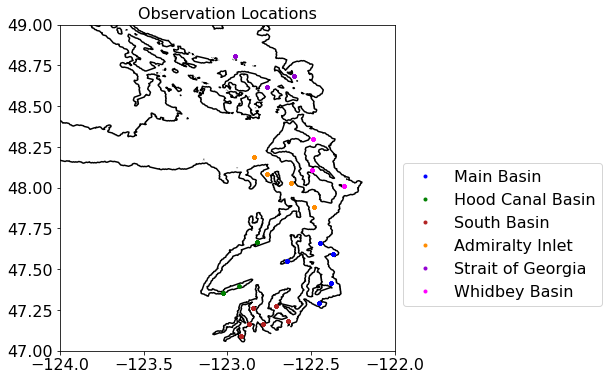

In [9]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

In [10]:
#creating new dictionaries that make it easy to call on specific years.
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datreg=dict()
for iregion in data.Basin.unique():
    datreg[iregion] = data.loc[data.Basin==iregion] 
    
datyear=dict()
for ind, iyear in enumerate(data.dtUTC.dt.year.unique()):
    datyear[iyear] = data.loc[data.dtUTC.dt.year==iyear]
    
#Adding extra columns to assist in chlorophyll analysis.
data_Pheo['log_Chl']=ket.logt(data_Pheo['Chla_Lab'])
data_Pheo['log_mod_diatoms']=ket.logt(data_Pheo['mod_diatoms']*1.8)
data_Pheo['log_mod_ciliates']=ket.logt(data_Pheo['mod_ciliates']*1.8)
data_Pheo['log_mod_flagellates']=ket.logt(data_Pheo['mod_flagellates']*1.8)
data_Pheo['mod_Chl']=((data_Pheo['mod_diatoms']*1.8)+(data_Pheo['mod_ciliates']*1.8)+(data_Pheo['mod_flagellates']*1.8))
data_Pheo['log_mod_Chl']=ket.logt((data_Pheo['mod_diatoms']*1.8)+(data_Pheo['mod_ciliates']*1.8)+(data_Pheo['mod_flagellates']*1.8))

# defning a dictionary that brakes the data down by individual stations
datstat_Pheo=dict()
for ind, istation in enumerate(data_Pheo.Station.unique()):
    datstat_Pheo[istation]=data_Pheo.loc[data_Pheo.Station == istation]

datreg_Pheo=dict()
for iregion in data_Pheo.Basin.unique():
    datreg_Pheo[iregion] = data_Pheo.loc[data_Pheo.Basin==iregion] 
    
datyear_Pheo=dict()
for iyear in data_Pheo.dtUTC.dt.year.unique():
    datyear_Pheo[iyear] = data_Pheo.loc[data_Pheo.dtUTC.dt.year==iyear]

### Experimenting with individual station time series timeseries. 
Ideas include:
- Complicated but dense by region graphs whith a variety of colours and shapes representing stations. <font color='red'>This did not work at all, the points are just too close together for anything clear to develop</font>
- A group of micrographs for each station. 
- A group of micrographs for each station but with the model output plotted as an actual timeseries line. 

In [114]:
#Individual large plots. 
markers=('*','D','o','X','P','s')
ocols='blue'
mcols='fuchsia'

start_date=dt.datetime(year,1,1),
end_date=dt.datetime(year,12,31)

def TsByStation_full (ax,df,region,obsvar,modvar,units='($\mu$M)',omark='o',mmark='x',
                 cols=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
                'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')):
    ps = []
    for ind, istation in enumerate(df[df['Basin'] == region].Station.unique()):  
        obs0=et._deframe(df.loc[(df['Station'] == istation),[obsvar]])
        mod0=et._deframe(df.loc[(df['Station'] == istation),[modvar]])
        time0=et._deframe(df.loc[(df['Station'] == istation),['dtUTC']])
        p0,=ax.plot(time0,obs0,'.',color=cols[ind],marker=omark,label=f'{istation} obs',fillstyle='none',alpha=0.5)
        ps.append(p0)
        p0,=ax.plot(time0,mod0,'.',color=cols[ind],marker=mmark,label=f'{istation} mod',fillstyle='none')
        ps.append(p0)
        ax.legend(handles=ps,bbox_to_anchor=[1,.6,0,0])
    yearsFmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(yearsFmt)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax.set_title(f'{obsvar} {units} in {region} by Station' )
    return ps

def trendline (ax,df,region,obsvar,modvar):
    df=df.sort_values(by='dtUTC').dropna()
    obs0=et._deframe(df.loc[(df['Basin'] == region),[obsvar]])
    mod0=et._deframe(df.loc[(df['Basin'] == region),[modvar]])
    timepy=df[df['Basin'] == 'South Basin'].dtUTC.dt.to_pydatetime()
    time0=et._deframe(timepy)
    yd=[]
    for i in time0:
        yd.append((i - dt.datetime(i.year, 1, 1)).days + 1)
    coefso = poly.polyfit(yd,obs0,4)
    ffito = poly.polyval(yd, coefso)
    coefsm = poly.polyfit(yd,mod0,4)
    ffitm = poly.polyval(yd, coefsm)
    ax.plot(time0, ffito, color='blue')
    ax.plot(time0, ffitm, color='green')

def TsByStation_ind (df,datstat,regions,obsvar,modvar,year,ylim,figsize=(14,40),loc='lower left'):  
    stations=[]
    for r in regions:
        sta0=df[df['Basin']==r].Station.unique()
        stations.append(sta0)
    stations = [val for sublist in stations for val in sublist]
    fig,ax=plt.subplots(math.ceil(len(stations)/2),2,figsize=figsize)
    new_stat = [stations[i:i+2] for i in range(0, len(stations), 2)]
    for si,axi in zip(new_stat,ax):
        for sj,axj in zip(si,axi):
            ps=ket.tsertser_graph(axj,datstat[sj],obsvar,modvar,dt.datetime(year,1,1),dt.datetime(year,12,31))
            axj.legend(handles=ps,prop={'size': 10},loc=loc)
            axj.set_xlabel(f'Date',fontsize=13)
            axj.set_ylabel(f'{obsvar} ($\mu$M)',fontsize=13)
            axj.set_title(f'{df[df.Station==sj].Basin.unique()[0]} ({sj})', fontsize=13)
            axj.set_ylim(ylim)
            yearsFmt = mdates.DateFormatter('%d %b')
            axj.xaxis.set_major_formatter(yearsFmt)
            for tick in axj.xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
            for tick in axj.yaxis.get_major_ticks():
                tick.label.set_fontsize(13)
            plt.tight_layout()
            plt.setp(axj.get_xticklabels(), rotation=30, horizontalalignment='right')

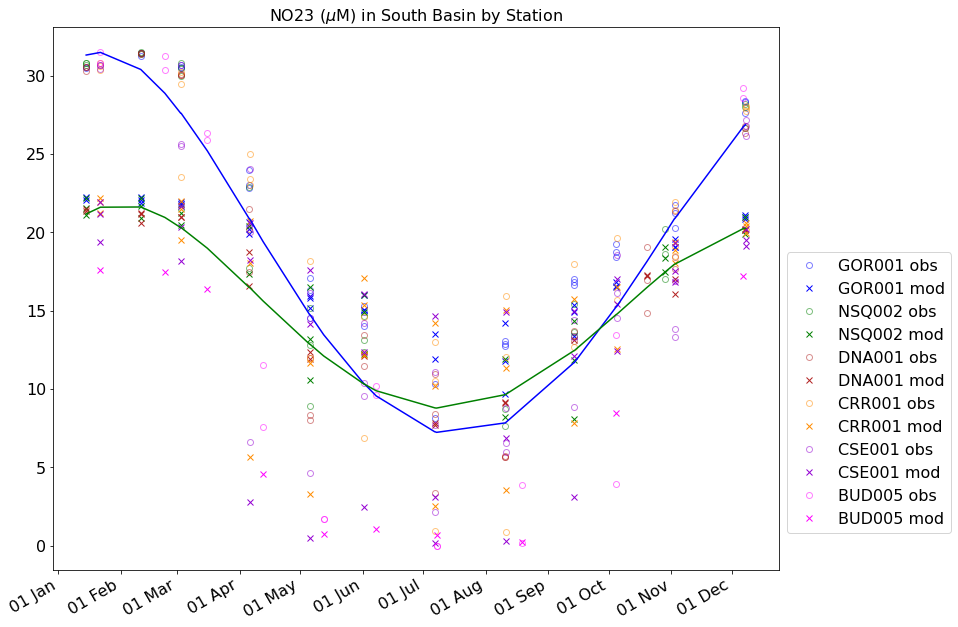

In [115]:
obsvar='NO23'
modvar='mod_nitrate'

fig, ax=plt.subplots(1,1,figsize=(13,10))
ps=TsByStation_full(ax,data,'South Basin',obsvar,modvar)

trendline(ax,data,'South Basin',obsvar,modvar)

#might find it somewhat useful to use the alpha variable to make them semi transparent.
#Plotting a trendline for the whole region, but also able to see the point. 

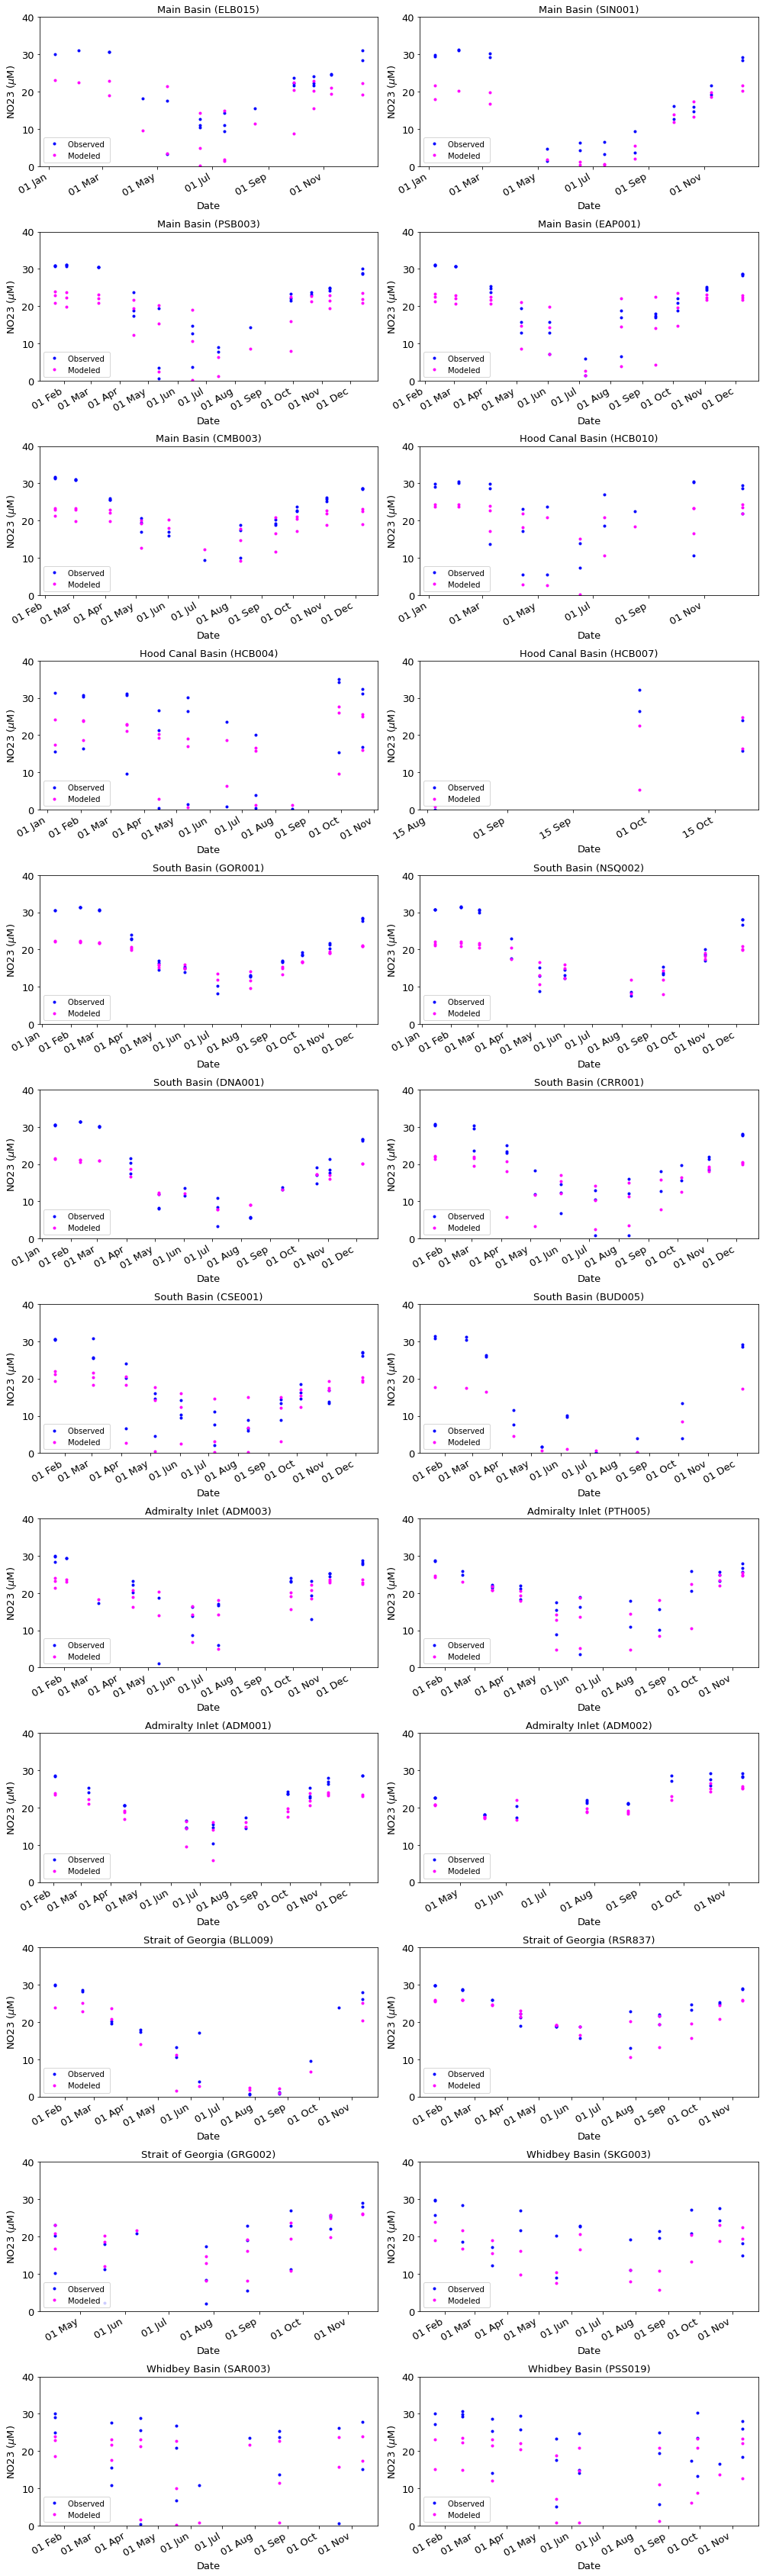

In [13]:
regions=data.Basin.unique()
lims=(0,40)
TsByStation_ind(data,datstat,regions,obsvar,modvar,year,lims,figsize=(14,47),loc='lower left')

these are good but also have a main plot that is following the idea of the other one. 